In [2]:
from matplotlib import pyplot
from functools import partial
import numpy
import pandas
import ROOT

In [3]:
### UTILS
def round_to_nearest_5(n) -> int:
    r = round(n, -1)
    return r if r > n  else r + 5

def get_y_min_max(graph1, graph2) -> tuple[float, float]:
    n_1 = graph1.GetN()
    y_1 = graph1.GetY()
    n_2 = graph2.GetN()
    y_2 = graph2.GetY()

    ymin_1 = ROOT.TMath.MinElement(n_1, y_1)
    ymax_1 = ROOT.TMath.MaxElement(n_1, y_1)

    ymin_2 = ROOT.TMath.MinElement(n_2, y_2)
    ymax_2 = ROOT.TMath.MaxElement(n_2, y_2)
    
    return min(ymin_1, ymin_2), max(ymax_1, ymax_2)

def get_x_min_max(graph1, graph2) -> tuple[float, float]:
    n_1 = graph1.GetN()
    x_1 = graph1.GetX()
    n_2 = graph2.GetN()
    x_2 = graph2.GetX()

    xmin_1 = ROOT.TMath.MinElement(n_1, x_1)
    xmax_1 = ROOT.TMath.MaxElement(n_1, x_1)

    xmin_2 = ROOT.TMath.MinElement(n_2, x_2)
    xmax_2 = ROOT.TMath.MaxElement(n_2, x_2)
    
    return min(xmin_1, xmin_2), max(xmax_1, xmax_2)

def create_mpl_tcolors() -> dict[str, ROOT.TColor]:
    import matplotlib.colors as mcolors
    return {
        name: ROOT.TColor.GetColor(color)
        for name, color in mcolors.TABLEAU_COLORS.items()
        
    }

PYPLOT_TCOLORS = create_mpl_tcolors()

In [4]:
df = pandas.read_csv("results.csv")
df

,nodes,corespernode,partitions,time
0,3,32,64,159.99
1,2,32,32,275.62
2,3,32,64,139.64
3,2,16,16,477.43
4,3,32,64,123.55
5,2,32,32,237.30
6,3,32,64,125.62
7,5,32,128,83.84
8,2,32,32,198.75
9,2,8,8,756.14


In [5]:
size_GB = 188
nevts = 765_723_174

In [6]:
df["nodes"] = df["nodes"] - 1
df

,nodes,corespernode,partitions,time
0,2,32,64,159.99
1,1,32,32,275.62
2,2,32,64,139.64
3,1,16,16,477.43
4,2,32,64,123.55
5,1,32,32,237.30
6,2,32,64,125.62
7,4,32,128,83.84
8,1,32,32,198.75
9,1,8,8,756.14


In [48]:
def sem(data):
    return numpy.std(data, ddof=1)/numpy.sqrt(numpy.size(data))

df_avg = df.groupby(["nodes","corespernode","partitions"]).mean("time").reset_index()
df_std = df.groupby(["nodes","corespernode","partitions"]).agg({"time":numpy.std}).reset_index()
df_sem = df.groupby(["nodes","corespernode","partitions"]).agg({"time":sem}).reset_index()

df_avg["total_cores"] = df_avg.nodes * df_avg.corespernode
df_avg["throughput_GB_s"] = size_GB / df_avg["time"]
df_avg["throughput_evts"] = nevts / df_avg["time"] / 1e3
df_avg["speedup"] = df_avg["throughput_GB_s"] / df_avg["throughput_GB_s"].iloc[0]
df_avg["std"] = df_std["time"]
df_avg["sem"] = df_sem["time"]
df_avg

,nodes,corespernode,partitions,time,total_cores,throughput_GB_s,throughput_evts,speedup,std,sem
0,1,1,1,5678.965,1,0.033105,134.834987,1.000000,359.001372,146.561697
1,1,2,2,3078.148,2,0.061076,248.761000,1.844929,195.429852,87.398887
2,1,4,4,1486.318,4,0.126487,515.181256,3.820828,224.620683,100.453423
3,1,8,8,757.980,8,0.248028,1010.215539,7.492236,118.278500,52.895753
4,1,16,16,398.600,16,0.471651,1921.031545,14.247278,48.485254,21.683265
5,1,32,32,224.942,32,0.835771,3404.091606,25.246352,32.221069,14.409700
6,2,32,64,135.074,64,1.391830,5668.916105,42.043361,15.298318,6.841616
7,4,32,128,71.276,128,2.637634,10743.071637,79.675697,8.806619,3.938440
8,8,32,256,49.506,256,3.797519,15467.280208,114.712661,5.825713,2.605338


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


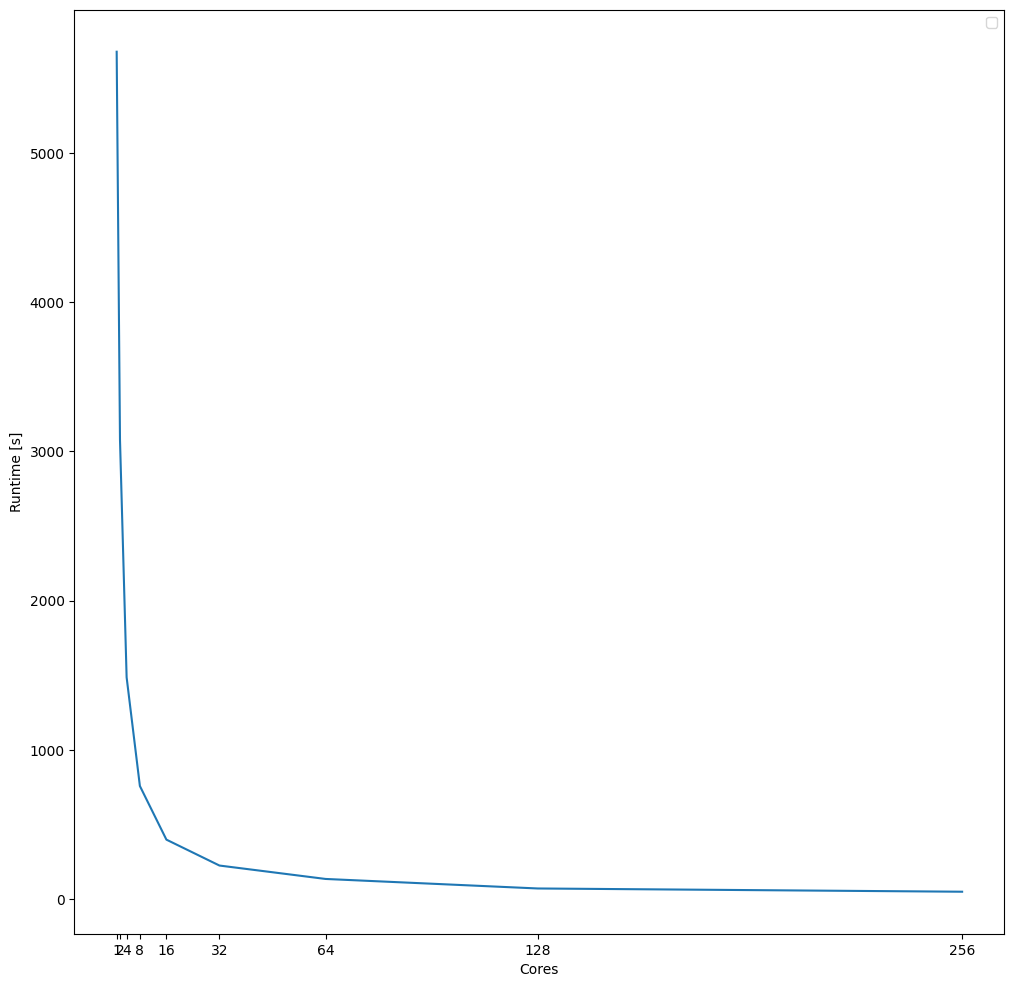

In [8]:
# Plot
fig, ax = pyplot.subplots(figsize=(12,12))
pyplot.xticks(df_avg.total_cores)
pyplot.xlabel("Cores")
pyplot.ylabel("Runtime [s]")
ax.plot(df_avg.total_cores, df_avg.time)
ax.legend()

# TGraph

Info in <TCanvas::Print>: png file throughput.png has been created


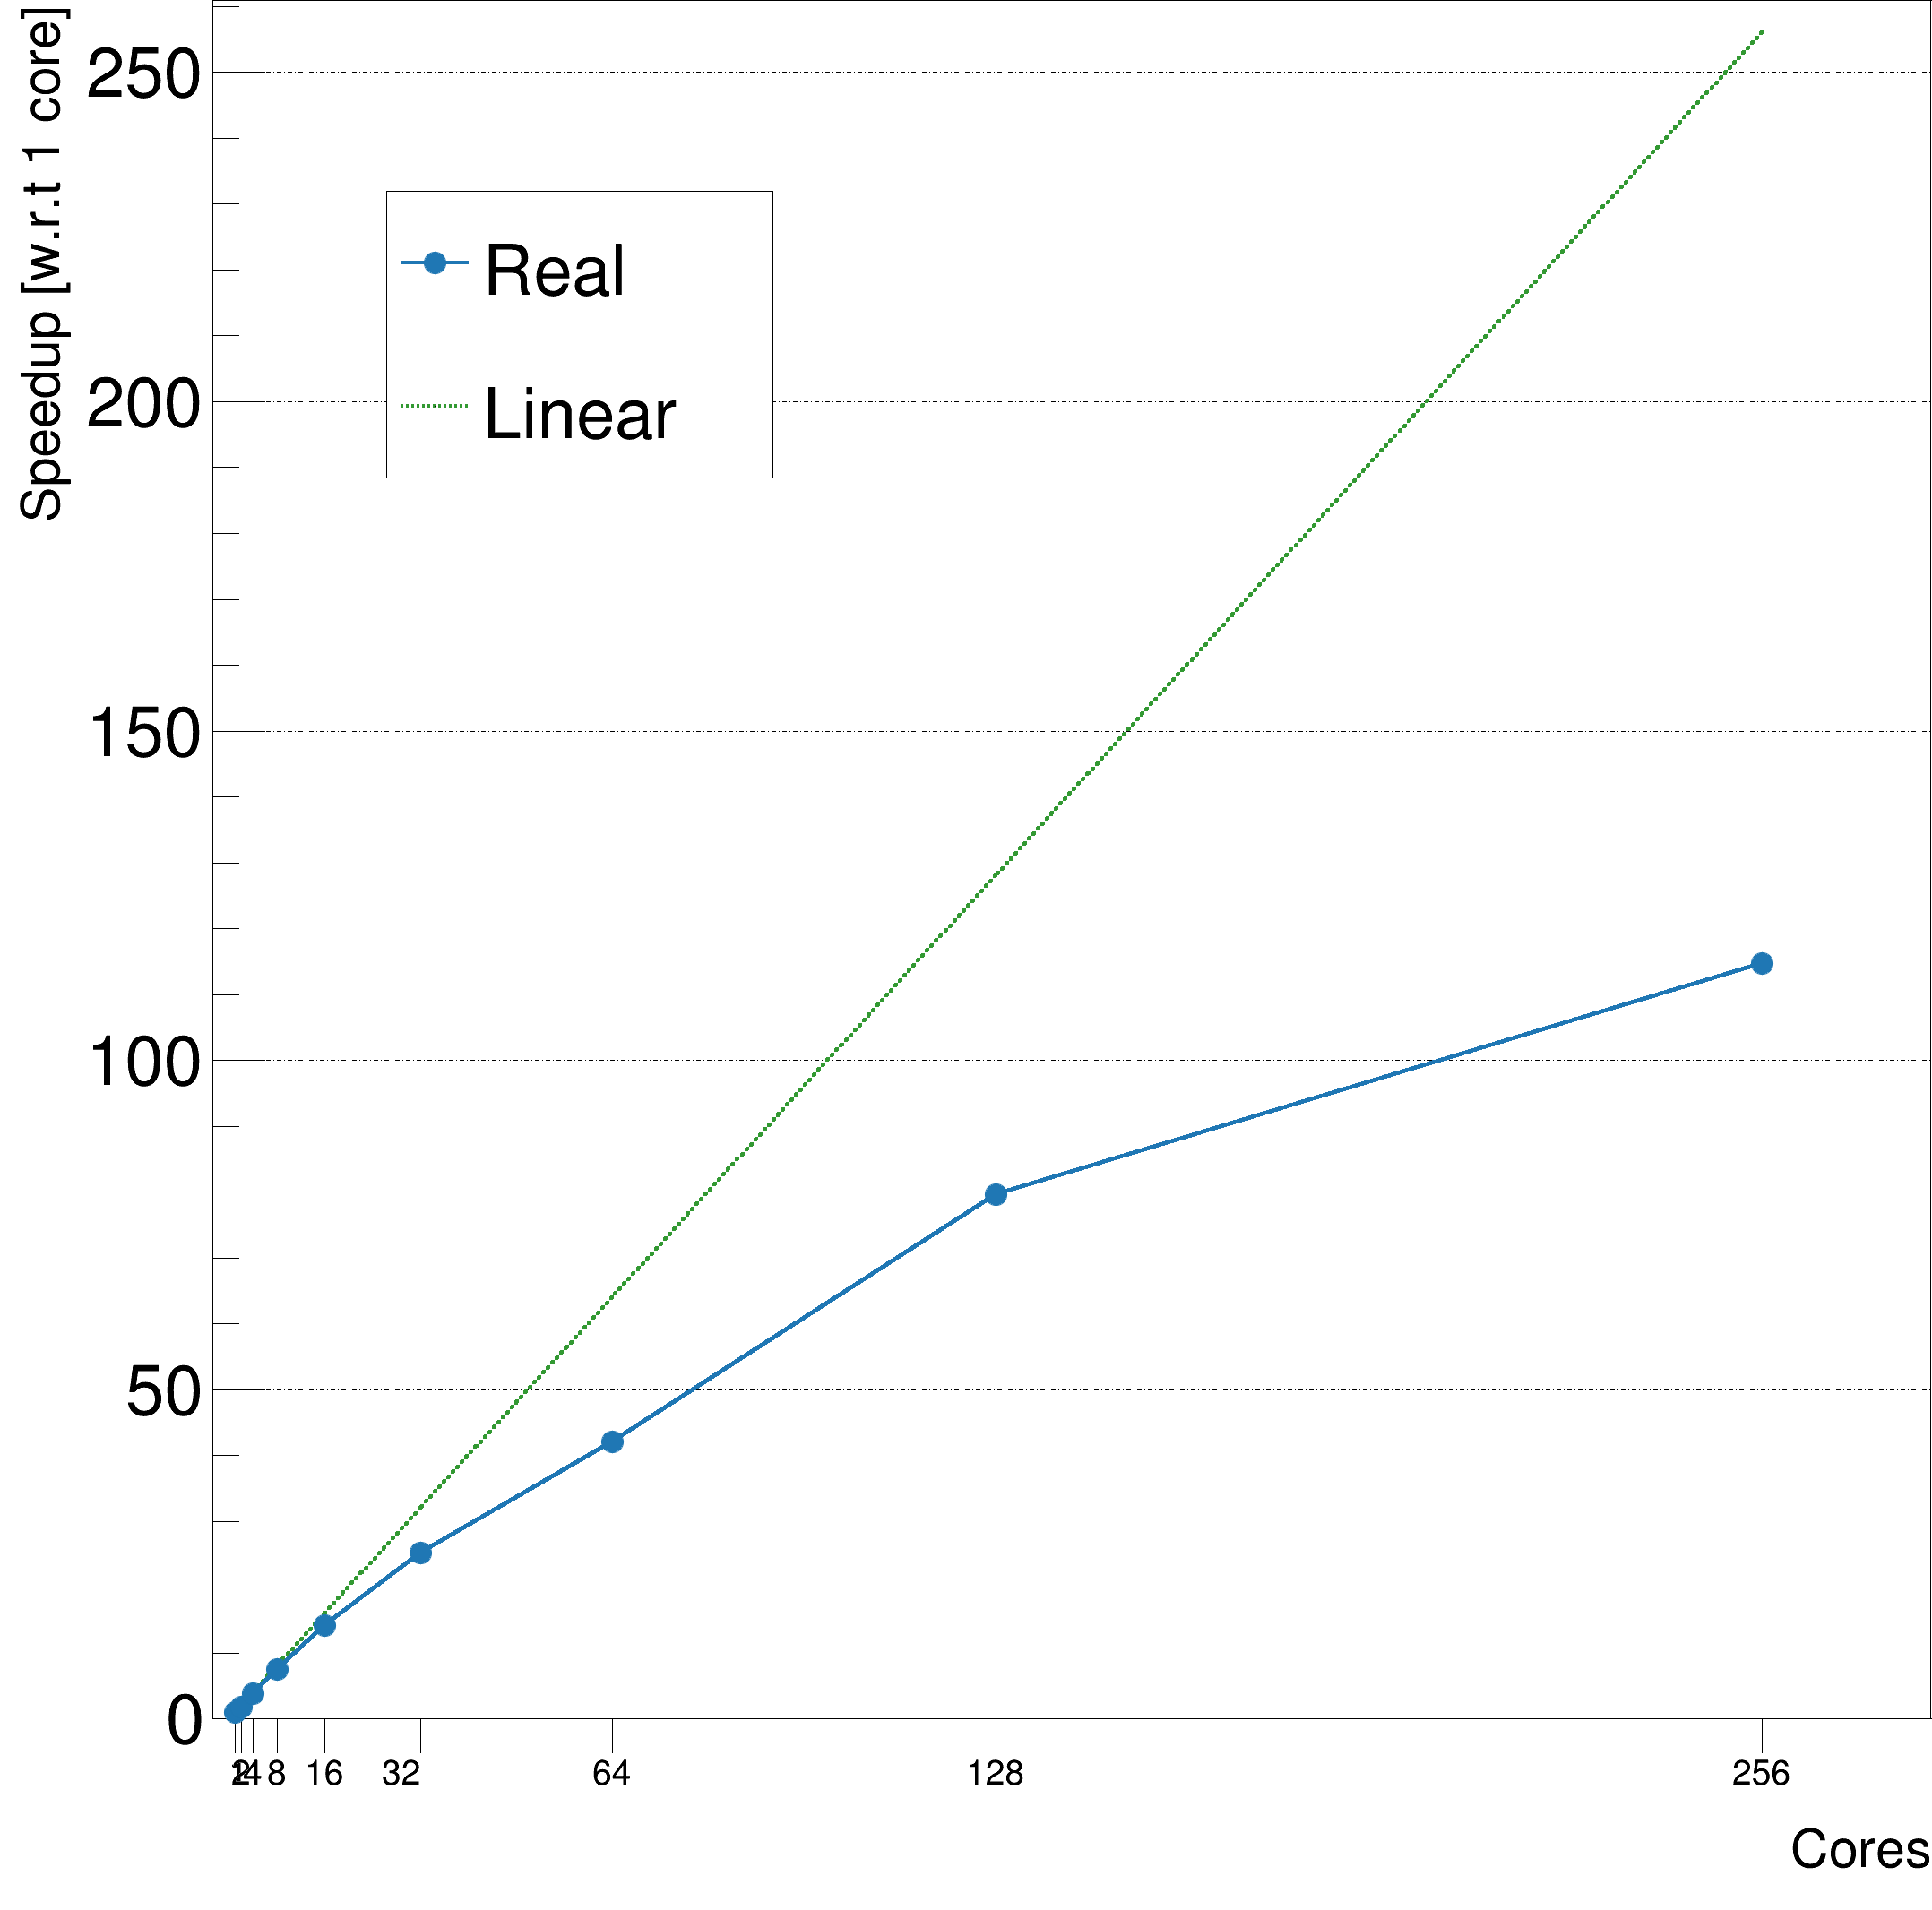

In [9]:
sparkgraph_cold = ROOT.TGraph(len(df_avg.total_cores),
                              numpy.array(df_avg.total_cores, dtype=float),
                              numpy.array(df_avg.speedup, dtype=float))

idealspeedupgraph = ROOT.TGraph(len(df_avg.total_cores),
                                numpy.array(df_avg.total_cores, dtype=float),
                                numpy.array(df_avg.total_cores, dtype=float))

width = 2160
height = 2160
c = ROOT.TCanvas("c", "", width, height)

ymin, ymax = get_y_min_max(idealspeedupgraph, sparkgraph_cold)

idealspeedupgraph.SetTitle("")

idealspeedupgraph.GetXaxis().SetTitle("Cores")
idealspeedupgraph.GetXaxis().SetTitleSize(0.03)
idealspeedupgraph.GetXaxis().SetTitleOffset(1.4)
idealspeedupgraph.GetXaxis().SetLabelSize(0)
idealspeedupgraph.GetXaxis().SetTickLength(0)
idealspeedupgraph.GetXaxis().SetRangeUser(-5,300)

idealspeedupgraph.GetYaxis().SetTitle("Speedup [w.r.t 1 core]")
idealspeedupgraph.GetYaxis().SetTitleSize(0.03)
idealspeedupgraph.GetYaxis().SetTitleOffset(1.8)
idealspeedupgraph.GetYaxis().SetRangeUser(0, ymax+5)
idealspeedupgraph.GetYaxis().SetLabelSize(0.04)
#idealspeedupgraph.GetYaxis().SetTickLength(0)

#idealspeedupgraph.SetMarkerColor(ROOT.kAzure-3)
#idealspeedupgraph.SetMarkerSize(1)
#idealspeedupgraph.SetMarkerStyle(20)
idealspeedupgraph.SetLineStyle(ROOT.kDashed)
idealspeedupgraph.SetLineColorAlpha(PYPLOT_TCOLORS["tab:green"],1)
idealspeedupgraph.SetLineWidth(4)
idealspeedupgraph.Draw("AL")



dy = ymax - ymin
xlabels = []
xticks = []
#ylabels = []
#yticks = []

for i in range(len(df_avg.total_cores)):
    x = idealspeedupgraph.GetPointX(i)
    y = idealspeedupgraph.GetPointY(i)

    xt = ROOT.TLatex(x, -10, str(int(x)))
    xt.SetTextSize(0.02)
    xt.SetTextFont(42)
    if x == 32: # left-align the 1 node point
        xt.SetTextAlign(31)
    else:
        xt.SetTextAlign(21)
    xt.Draw()
    xlabels.append(xt)

    xl = ROOT.TLine(x, 0, x,0-0.02*dy)
    xl.Draw()
    xticks.append(xl)
    
#    yt = ROOT.TLatex(-50, y-0.2, str(int(y)))
#    yt.SetTextSize(0.03)
#    yt.SetTextFont(42)
#    yt.SetTextAlign(21)
#    yt.Draw()
#    ylabels.append(yt)
#
#    yl = ROOT.TLine(0, y, 50, y)
#    yl.Draw()
#    yticks.append(yl)


sparkgraph_cold.GetYaxis().SetLabelSize(0)
sparkgraph_cold.SetMarkerSize(3)
sparkgraph_cold.SetMarkerStyle(20)
sparkgraph_cold.SetMarkerColor(PYPLOT_TCOLORS["tab:blue"])
sparkgraph_cold.SetLineStyle(ROOT.kSolid)
sparkgraph_cold.SetLineColorAlpha(PYPLOT_TCOLORS["tab:blue"],1)
sparkgraph_cold.SetLineWidth(4)

sparkgraph_cold.Draw("SAME PL")

legend = ROOT.TLegend(0.2,0.75,0.4,0.9)
legend.AddEntry(sparkgraph_cold, "Real")
legend.AddEntry(idealspeedupgraph, "Linear")
legend.Draw()

ROOT.gStyle.SetLegendTextSize(0.04)
ROOT.gStyle.SetGridWidth(1)
ROOT.gStyle.SetGridStyle(5)
c.SetGridy()

c.SetRightMargin(0)
c.SetLeftMargin(0.11)
c.SetTopMargin(0)
c.SetBottomMargin(0.1)

c.Draw()
c.SaveAs("throughput.png")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file speedup_log.png has been created


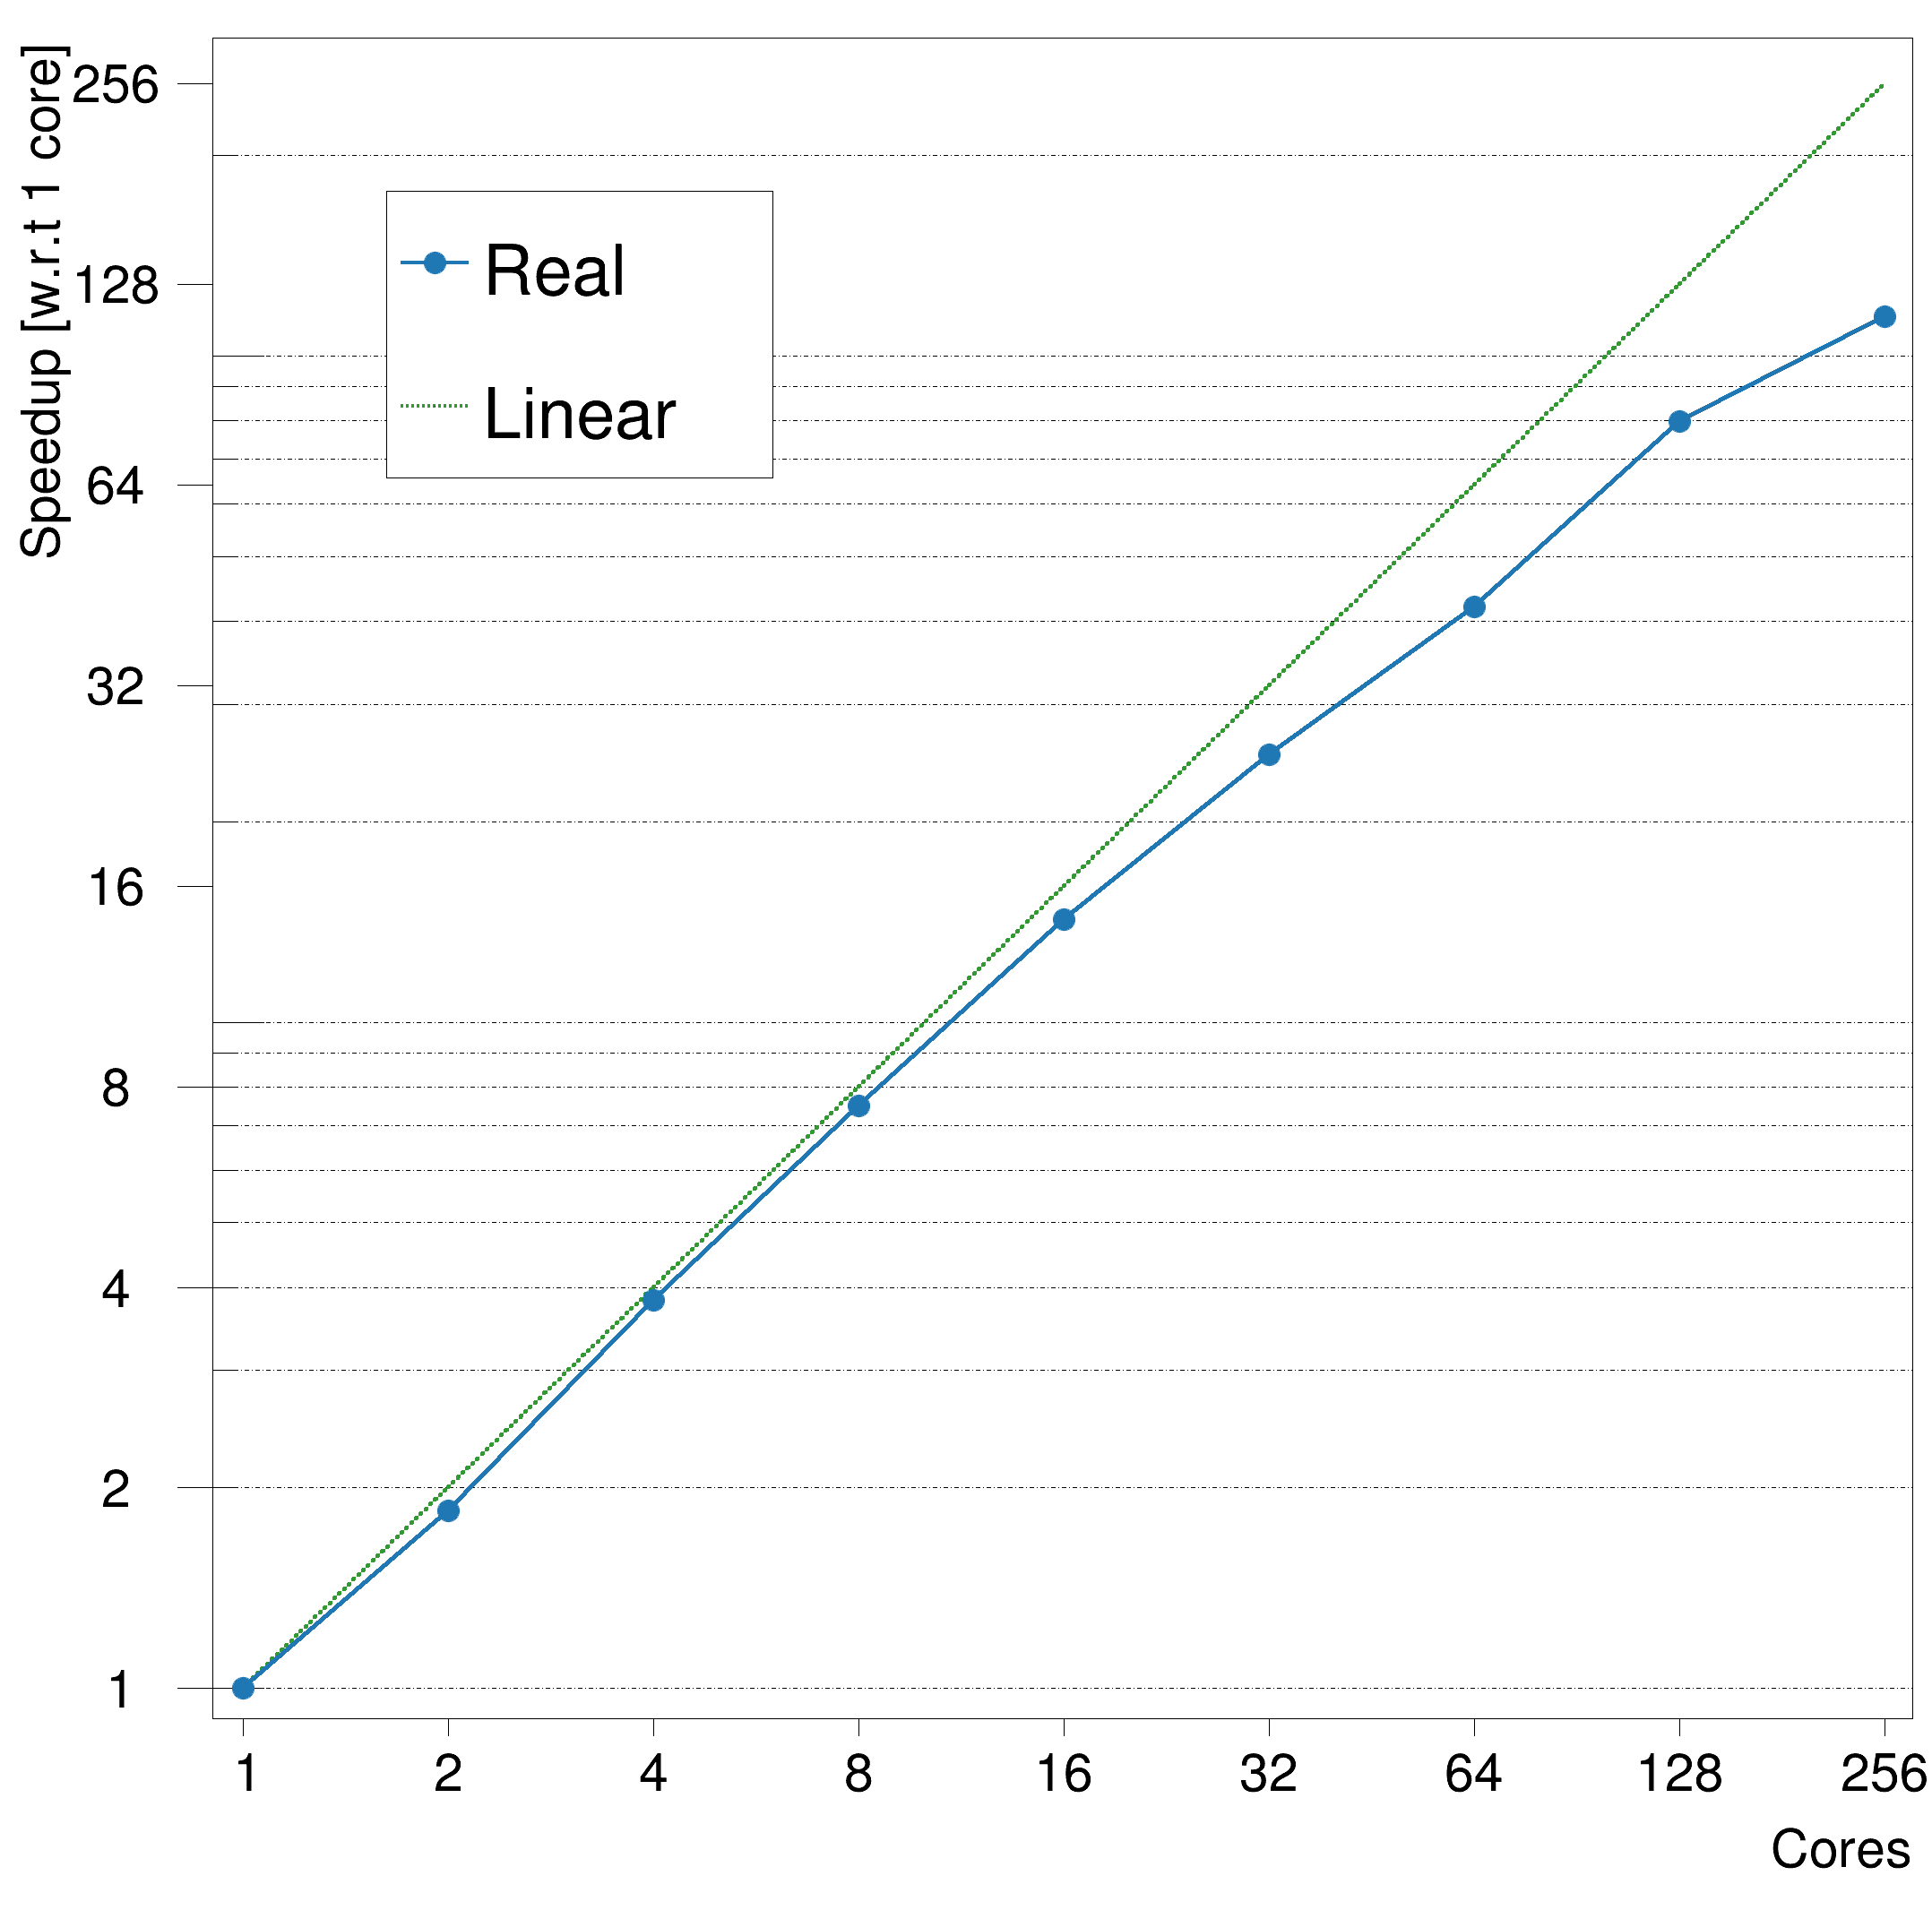

In [190]:
sparkgraph_cold = ROOT.TGraph(len(df_avg.total_cores),
                              numpy.array(df_avg.total_cores, dtype=float),
                              numpy.array(df_avg.speedup, dtype=float))

idealspeedupgraph = ROOT.TGraph(len(df_avg.total_cores),
                                numpy.array(df_avg.total_cores, dtype=float),
                                numpy.array(df_avg.total_cores, dtype=float))

width = 2160
height = 2160
c = ROOT.TCanvas("c", "", width, height)

ymin, ymax = get_y_min_max(idealspeedupgraph, sparkgraph_cold)
xaxis = idealspeedupgraph.GetXaxis()
yaxis = idealspeedupgraph.GetYaxis()

xaxis.SetMoreLogLabels()
xaxis.SetNoExponent()
yaxis.SetMoreLogLabels()
idealspeedupgraph.SetMinimum(0.9)
idealspeedupgraph.SetMaximum(300)

idealspeedupgraph.SetTitle("")

idealspeedupgraph.GetXaxis().SetTitle("Cores")
idealspeedupgraph.GetXaxis().SetTitleSize(0.03)
idealspeedupgraph.GetXaxis().SetTitleOffset(1.4)
idealspeedupgraph.GetXaxis().SetLabelSize(0)
idealspeedupgraph.GetXaxis().SetTickLength(0)
idealspeedupgraph.GetXaxis().SetRangeUser(-5,500)

idealspeedupgraph.GetYaxis().SetTitle("Speedup [w.r.t 1 core]")
idealspeedupgraph.GetYaxis().SetTitleSize(0.03)
idealspeedupgraph.GetYaxis().SetTitleOffset(1.8)
idealspeedupgraph.GetYaxis().SetRangeUser(0, ymax+5)
idealspeedupgraph.GetYaxis().SetLabelSize(0.04)
yaxis.SetLabelSize(0)

#idealspeedupgraph.SetMarkerColor(ROOT.kAzure-3)
#idealspeedupgraph.SetMarkerSize(1)
#idealspeedupgraph.SetMarkerStyle(20)
idealspeedupgraph.SetLineStyle(ROOT.kDashed)
idealspeedupgraph.SetLineColorAlpha(PYPLOT_TCOLORS["tab:green"],1)
idealspeedupgraph.SetLineWidth(4)
idealspeedupgraph.Draw("AL")



"""
for i in range(len(df_avg.total_cores)):
    x = idealspeedupgraph.GetPointX(i)
    y = idealspeedupgraph.GetPointY(i)

    if i % 2 == 0:
        xt = ROOT.TLatex(x, -10, str(int(x)))
    else:
        xt = ROOT.TLatex(x, -15, str(int(x))) 
    xt.SetTextSize(0.02)
    xt.SetTextFont(42)

    if i == 0: # left-align the 1 node point
        xt.SetTextAlign(31)
    else:
        xt.SetTextAlign(21)

    xt.Draw()
    xlabels.append(xt)

    if i % 2 == 0:
        xl = ROOT.TLine(x, 0, x,-0.02*dy)
    else:
        xl = ROOT.TLine(x, 0, x,-0.035*dy)
    
    xl.Draw()
    xticks.append(xl)
"""

sparkgraph_cold.GetYaxis().SetLabelSize(0)
sparkgraph_cold.SetMarkerSize(3)
sparkgraph_cold.SetMarkerStyle(20)
sparkgraph_cold.SetMarkerColor(PYPLOT_TCOLORS["tab:blue"])
sparkgraph_cold.SetLineStyle(ROOT.kSolid)
sparkgraph_cold.SetLineColorAlpha(PYPLOT_TCOLORS["tab:blue"],1)
sparkgraph_cold.SetLineWidth(4)

sparkgraph_cold.Draw("SAME PL")

legend = ROOT.TLegend(0.2,0.75,0.4,0.9)
legend.AddEntry(sparkgraph_cold, "Real")
legend.AddEntry(idealspeedupgraph, "Linear")
legend.Draw()

ROOT.gStyle.SetLegendTextSize(0.04)
ROOT.gStyle.SetGridWidth(1)
ROOT.gStyle.SetGridStyle(5)
c.SetLogx()
c.SetLogy()
c.SetGridy()

c.SetRightMargin(0.01)
c.SetLeftMargin(0.11)
c.SetTopMargin(0.02)
c.SetBottomMargin(0.1)

dy = ymax - ymin
xlabels = []
xticks = []
ylabels = []
yticks = []
for i in range(len(df_avg.total_cores)):
    x = idealspeedupgraph.GetPointX(i)
    y = idealspeedupgraph.GetPointY(i)
    xt = ROOT.TLatex()
    xt.SetTextSize(0.03)
    xt.SetTextFont(42)

    xt.SetTextAlign(21)
    xt.DrawLatex(x,0.7, str(int(x))) # For some reason only this works in log axis
    xlabels.append(xt)

    xl = ROOT.TLine()
    xl.DrawLine(x,0,x,0.85)
    xticks.append(xl)

    yt = ROOT.TLatex()
    yt.SetTextSize(0.03)
    yt.SetTextFont(42)
    yt.SetTextAlign(22)
    yt.DrawLatex(0.65, y, str(int(y)))
    ylabels.append(yt)

    yl = ROOT.TLine()
    yl.DrawLine(0.8, y, 0.9, y)
    yticks.append(yl)


c.Draw()
c.SaveAs("speedup_log.png")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file runtime_log.png has been created


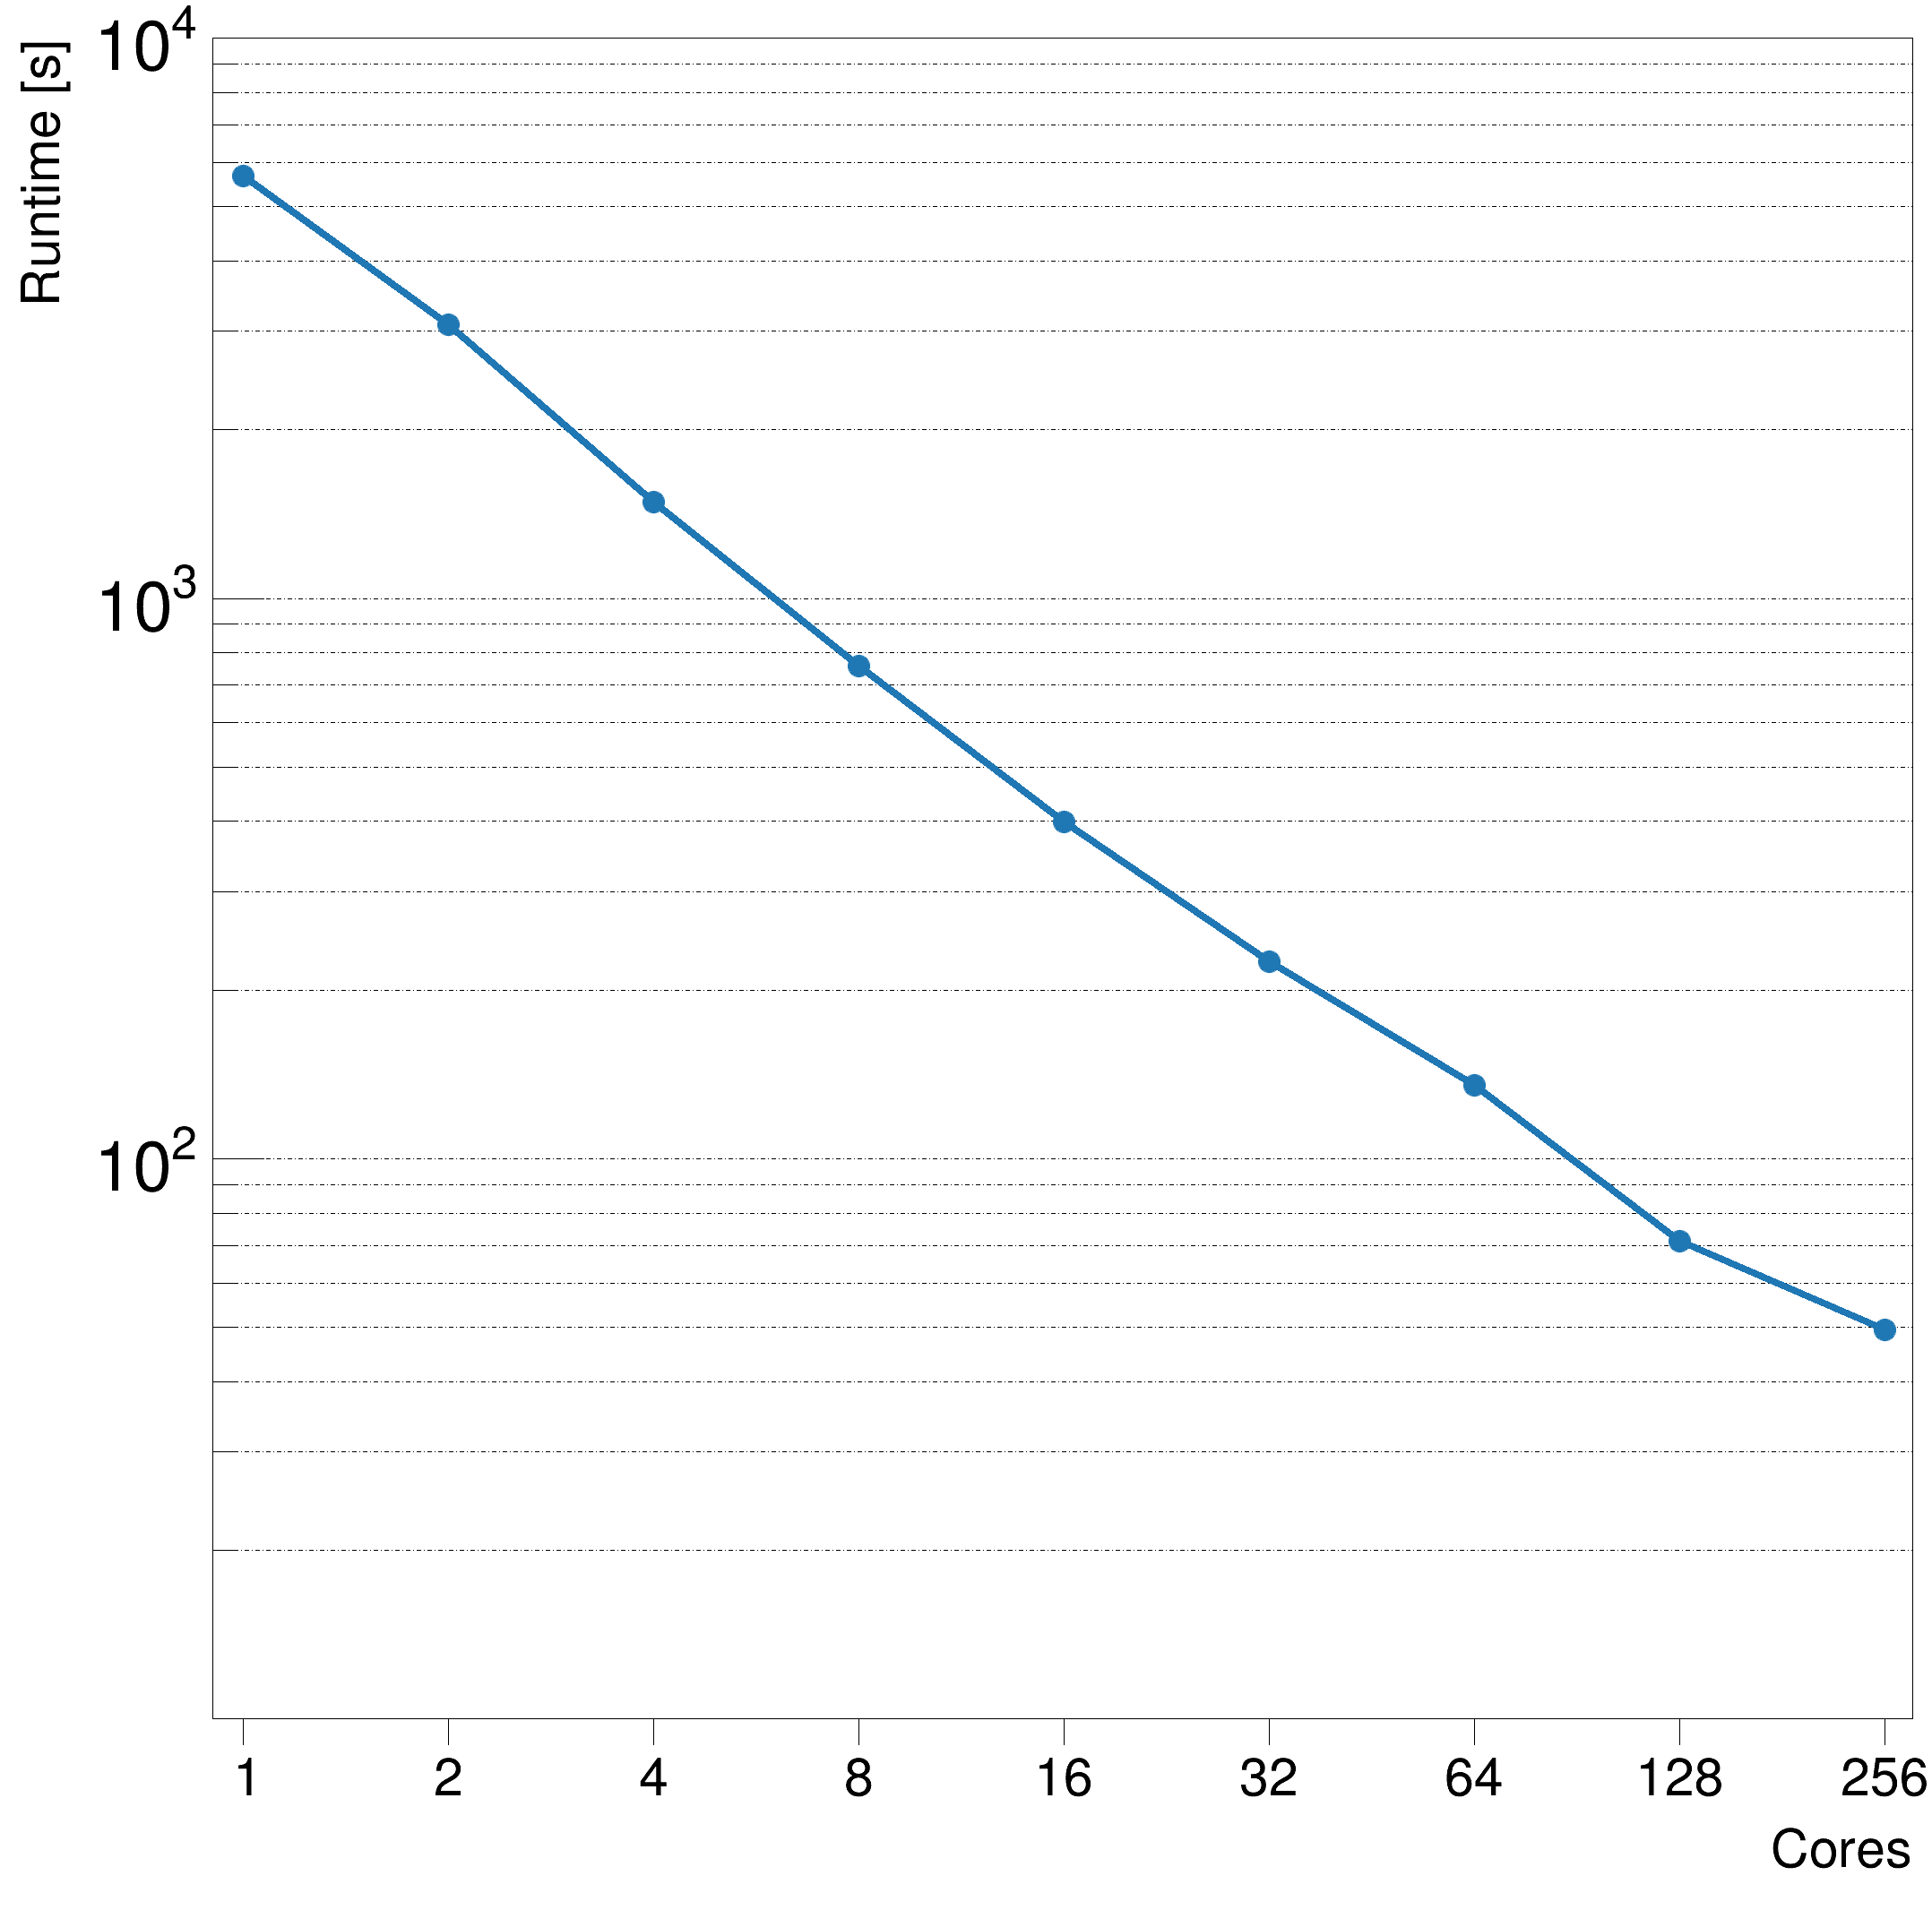

In [196]:
idealspeedupgraph = ROOT.TGraph(len(df_avg.total_cores),
                                numpy.array(df_avg.total_cores, dtype=float),
                                numpy.array(df_avg.time, dtype=float))

width = 2160
height = 2160
c = ROOT.TCanvas("c", "", width, height)

ymin, ymax = get_y_min_max(idealspeedupgraph, idealspeedupgraph)

idealspeedupgraph.SetTitle("")

xaxis = idealspeedupgraph.GetXaxis()
yaxis = idealspeedupgraph.GetYaxis()

idealspeedupgraph.GetXaxis().SetTitle("Cores")
idealspeedupgraph.GetXaxis().SetTitleSize(0.03)
idealspeedupgraph.GetXaxis().SetTitleOffset(1.4)
idealspeedupgraph.GetXaxis().SetLabelSize(0)
idealspeedupgraph.GetXaxis().SetTickLength(0)
idealspeedupgraph.GetXaxis().SetRangeUser(-5,500)

idealspeedupgraph.GetYaxis().SetTitle("Runtime [s]")
idealspeedupgraph.GetYaxis().SetTitleSize(0.03)
idealspeedupgraph.GetYaxis().SetTitleOffset(1.8)
idealspeedupgraph.GetYaxis().SetRangeUser(0, ymax)
idealspeedupgraph.GetYaxis().SetLabelSize(0.04)
#idealspeedupgraph.GetYaxis().SetTickLength(0)

idealspeedupgraph.SetMarkerColor(PYPLOT_TCOLORS["tab:blue"])
idealspeedupgraph.SetMarkerSize(3)
idealspeedupgraph.SetMarkerStyle(20)
idealspeedupgraph.SetLineStyle(ROOT.kSolid)
idealspeedupgraph.SetLineColorAlpha(PYPLOT_TCOLORS["tab:blue"],1)
idealspeedupgraph.SetLineWidth(6)

xaxis.SetMoreLogLabels()
xaxis.SetNoExponent()
yaxis.SetMoreLogLabels()

idealspeedupgraph.SetMinimum(10)
idealspeedupgraph.SetMaximum(1e4)
idealspeedupgraph.Draw("ALP")



#ylabels = []
#yticks = []
 
#    yt = ROOT.TLatex(-50, y-0.2, str(int(y)))
#    yt.SetTextSize(0.03)
#    yt.SetTextFont(42)
#    yt.SetTextAlign(21)
#    yt.Draw()
#    ylabels.append(yt)
#
#    yl = ROOT.TLine(0, y, 50, y)
#    yl.Draw()
#    yticks.append(yl)



#sparkgraph_cold.GetYaxis().SetLabelSize(0)
#sparkgraph_cold.SetMarkerSize(3)
#sparkgraph_cold.SetMarkerStyle(20)
#sparkgraph_cold.SetMarkerColor(PYPLOT_TCOLORS["tab:blue"])
#sparkgraph_cold.SetLineStyle(ROOT.kSolid)
#sparkgraph_cold.SetLineColorAlpha(PYPLOT_TCOLORS["tab:blue"],1)
#sparkgraph_cold.SetLineWidth(4)

#sparkgraph_cold.Draw("SAME PL")

#legend = ROOT.TLegend(0.2,0.75,0.4,0.9)
#legend.AddEntry(sparkgraph_cold, "Real")
#legend.AddEntry(idealspeedupgraph, "Run")
#legend.Draw()


#ROOT.gStyle.SetLegendTextSize(0.04)
ROOT.gStyle.SetGridWidth(1)
ROOT.gStyle.SetGridStyle(5)
c.SetGridy()
c.SetLogy()
c.SetLogx()

c.SetRightMargin(0.01)
c.SetLeftMargin(0.11)
c.SetTopMargin(0.02)
c.SetBottomMargin(0.1)

dy = ymax - ymin
xlabels = []
xticks = []
for i in range(len(df_avg.total_cores)):
    x = idealspeedupgraph.GetPointX(i)
    y = idealspeedupgraph.GetPointY(i)
    xt = ROOT.TLatex()
    xt.SetTextSize(0.03)
    xt.SetTextFont(42)
    """
    if x == 32: # left-align the 1 node point
        xt.SetTextAlign(31)
    else:
        xt.SetTextAlign(21)
    """
    xt.SetTextAlign(21)
    xt.DrawLatex(x,7.3, str(int(x))) # For some reason only this works in log axis
    xlabels.append(xt)

    xl = ROOT.TLine()
    xl.DrawLine(x,0,x,9)
    xticks.append(xl)


c.Draw()
c.SaveAs("runtime_log.png")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file runtime_sem.png has been created


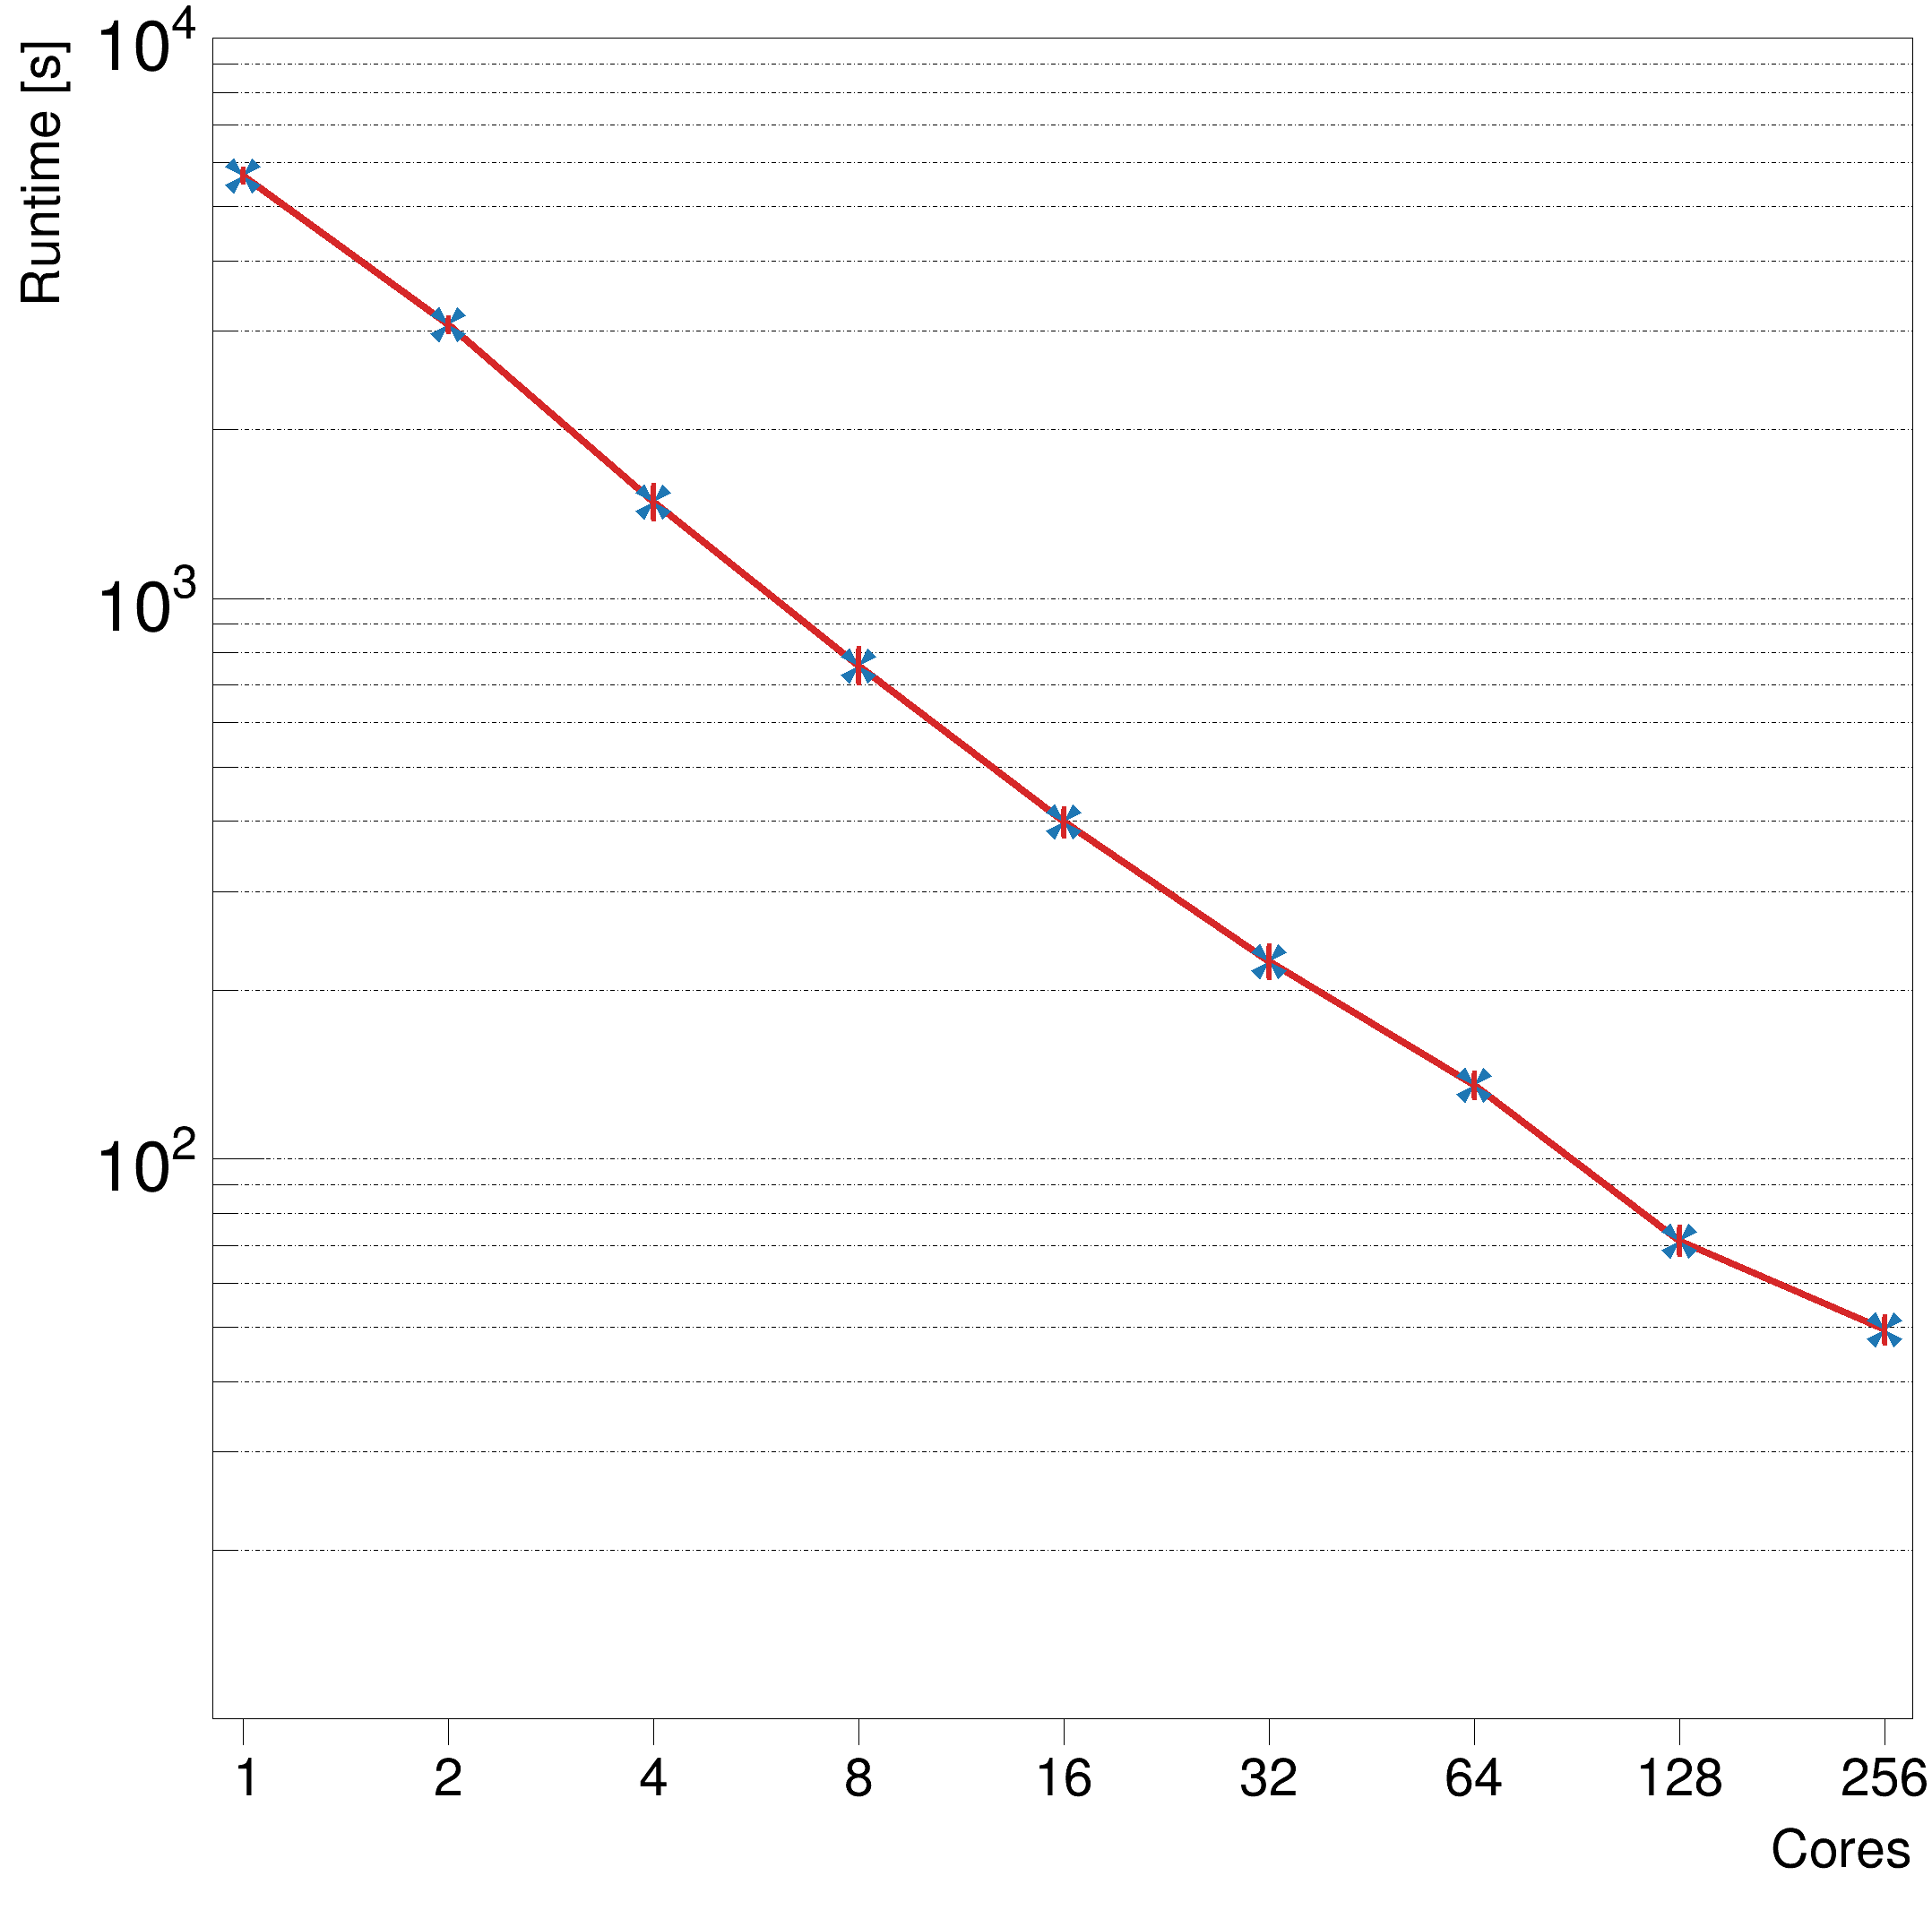

In [197]:
npoints = len(df_avg.total_cores)
valuesx = numpy.array(df_avg.total_cores, dtype=float)
valuesy = numpy.array(df_avg.time, dtype=float)
errx = 0
erry = numpy.array(df_avg["sem"], dtype=float)


idealspeedupgraph = ROOT.TGraphErrors(
    npoints,
    valuesx,
    valuesy,
    errx,
    erry
)


width = 2160
height = 2160
c = ROOT.TCanvas("c", "", width, height)

ymin, ymax = get_y_min_max(idealspeedupgraph, idealspeedupgraph)

idealspeedupgraph.SetTitle("")

xaxis = idealspeedupgraph.GetXaxis()
yaxis = idealspeedupgraph.GetYaxis()

idealspeedupgraph.GetXaxis().SetTitle("Cores")
idealspeedupgraph.GetXaxis().SetTitleSize(0.03)
idealspeedupgraph.GetXaxis().SetTitleOffset(1.4)
idealspeedupgraph.GetXaxis().SetLabelSize(0)
idealspeedupgraph.GetXaxis().SetTickLength(0)
idealspeedupgraph.GetXaxis().SetRangeUser(-5,500)

idealspeedupgraph.GetYaxis().SetTitle("Runtime [s]")
idealspeedupgraph.GetYaxis().SetTitleSize(0.03)
idealspeedupgraph.GetYaxis().SetTitleOffset(1.8)
idealspeedupgraph.GetYaxis().SetRangeUser(0, ymax)
idealspeedupgraph.GetYaxis().SetLabelSize(0.04)
idealspeedupgraph.GetYaxis().SetMoreLogLabels()
#idealspeedupgraph.GetYaxis().SetTickLength(0)

idealspeedupgraph.SetMarkerColor(PYPLOT_TCOLORS["tab:blue"])
idealspeedupgraph.SetMarkerSize(5)
idealspeedupgraph.SetMarkerStyle(41)
idealspeedupgraph.SetLineStyle(ROOT.kSolid)
idealspeedupgraph.SetLineColorAlpha(PYPLOT_TCOLORS["tab:red"],1)
idealspeedupgraph.SetLineWidth(6)

xaxis.SetMoreLogLabels()
xaxis.SetNoExponent()
yaxis.SetMoreLogLabels()

idealspeedupgraph.SetMinimum(10)
idealspeedupgraph.SetMaximum(1e4)
idealspeedupgraph.Draw("ALP")



#ylabels = []
#yticks = []
 
#    yt = ROOT.TLatex(-50, y-0.2, str(int(y)))
#    yt.SetTextSize(0.03)
#    yt.SetTextFont(42)
#    yt.SetTextAlign(21)
#    yt.Draw()
#    ylabels.append(yt)
#
#    yl = ROOT.TLine(0, y, 50, y)
#    yl.Draw()
#    yticks.append(yl)



#sparkgraph_cold.GetYaxis().SetLabelSize(0)
#sparkgraph_cold.SetMarkerSize(3)
#sparkgraph_cold.SetMarkerStyle(20)
#sparkgraph_cold.SetMarkerColor(PYPLOT_TCOLORS["tab:blue"])
#sparkgraph_cold.SetLineStyle(ROOT.kSolid)
#sparkgraph_cold.SetLineColorAlpha(PYPLOT_TCOLORS["tab:blue"],1)
#sparkgraph_cold.SetLineWidth(4)

#sparkgraph_cold.Draw("SAME PL")

#legend = ROOT.TLegend(0.2,0.75,0.4,0.9)
#legend.AddEntry(sparkgraph_cold, "Real")
#legend.AddEntry(idealspeedupgraph, "Run")
#legend.Draw()


#ROOT.gStyle.SetLegendTextSize(0.04)
ROOT.gStyle.SetGridWidth(1)
ROOT.gStyle.SetGridStyle(5)
c.SetGridy()
c.SetLogy()
c.SetLogx()

c.SetRightMargin(0.01)
c.SetLeftMargin(0.11)
c.SetTopMargin(0.02)
c.SetBottomMargin(0.1)

dy = ymax - ymin
xlabels = []
xticks = []
for i in range(len(df_avg.total_cores)):
    x = idealspeedupgraph.GetPointX(i)
    y = idealspeedupgraph.GetPointY(i)
    xt = ROOT.TLatex()
    xt.SetTextSize(0.03)
    xt.SetTextFont(42)
    """
    if x == 32: # left-align the 1 node point
        xt.SetTextAlign(31)
    else:
        xt.SetTextAlign(21)
    """
    xt.SetTextAlign(21)
    xt.DrawLatex(x,7.3, str(int(x))) # For some reason only this works in log axis
    xlabels.append(xt)

    xl = ROOT.TLine()
    xl.DrawLine(x,0,x,9)
    xticks.append(xl)


c.Draw()
c.SaveAs("runtime_sem.png")